In [58]:
%reset -f

In [84]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mip import Model, xsum, maximize, BINARY

Using Python-MIP package version 1.7.3


In [85]:
def mip_entropy_constrained(Lambda):
    Omega = 1
    p = Omega * all_dijs + Lambda * all_prb0s
    w = A_eq
    c = 1
    I = range(np.shape(w)[1])

    m = Model('knapsack')

    x = [m.add_var(var_type=BINARY) for i in I]

    m.objective = maximize(xsum(p[i] * x[i] for i in I))

    for j in range (0,cells_num):
        m += xsum(w[j][i] * x[i] for i in I) == c

    opt_value = m.optimize()

    # print('\n', mip_pairs_show)
    selected = [i for i in I if x[i].x >= 0.99]
    # print('selected items: {}'.format(selected))

    mip_pairs = []
    for i in I:
        mip_pair = x[i].x
        mip_pairs = np.append(mip_pairs, mip_pair)

    k = 0
    mip_xx = np.zeros([cells_num, cells_num])
    for i in range(0,cells_num):
        for j in range(i+1,cells_num):
            mip_xx[i,j] = mip_pairs[k]
            k +=1

    mip_pairs_show = np.array(np.where(mip_xx == 1))

    obj_value_db = 10*np.log10(m.objective_value)
    
    mip_dijs = mip_pairs * all_dijs
    mip_distortion = sum(mip_dijs)
    mip_db = 10 * np.log10(mip_distortion)

    mip_prb0s = mip_pairs * all_prb0s
    mip_prb0 = sum(mip_prb0s)
    if mip_prb0 == 0 or mip_prb0 == 1:
        mip_entropy = 0
    else:
        mip_entropy = -mip_prb0 * np.log2(mip_prb0)-(1-mip_prb0)*np.log2(1-mip_prb0)

    # print(opt_distortion)
    print('\n1_DE(dB)_lam'+str(Lambda),mip_db)
    print('1_H(S0)_lam'+str(Lambda), mip_entropy)

In [86]:
img_file = 'lena_gray_512.tif'
intensities = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
imf = np.float32(intensities)

#http://www.robertstocker.co.uk/jpeg/jpeg_new_10.htm
fqtable = np.array([[2,1,1,1,1,1,1,1],
                    [1,1,2,2,2,2,2,4],
                    [3,2,2,2,2,5,4,4],
                    [3,4,6,5,6,6,6,5],
                    [6,6,6,7,9,8,6,7],
                    [9,7,6,6,8,11,8,9],
                    [10,10,10,10,10,6,8,11],
                    [12,11,10,12,9,10,10,10]])

qtable = np.array([[16,11,10,16,24, 40, 51, 61],
                   [12,12,14,19,26, 58, 60, 55],
                   [14,13,16,24,40, 57, 69, 56],
                   [14,17,22,29,51, 87, 80, 62],
                   [18,22,37,56,68, 109,103,77],
                   [24,36,55,64,81, 104,113,92],
                   [49,64,78,87,103,121,120,101],
                   [72,92,95,98,112,100,103,99]])

all_nq_ac = []
all_fq_ac = []
for i in range(0,64):
    for j in range(0,64):
        blk = imf[8*i:8*(i+1), 8*j:8*(j+1)]
        dct = cv2.dct(blk)
        nq_coef = np.round(dct)
        nq_coef_ac = np.delete(nq_coef, [0,0])
        all_nq_ac = np.append(all_nq_ac, nq_coef_ac)
        
        fq_coef = np.round(dct/fqtable)
        fq_coef_ac = np.delete(fq_coef, [0,0])
        all_fq_ac = np.append(all_fq_ac, fq_coef_ac)

nq_u, nq_counts = np.unique(all_nq_ac, return_counts=True)
fq_u, fq_counts = np.unique(all_fq_ac, return_counts=True)

In [87]:
fq_u_256_raw = np.delete(fq_u, np.argwhere((fq_u > 256) | (fq_u < -256)))
fq_counts_256_raw = np.delete(fq_counts, np.argwhere((fq_u > 256) | (fq_u < -256)))
fq_u_256_1 = np.array(range(-256,257))
fq_u_256 = np.delete(fq_u_256_1, np.argwhere(fq_u_256_1 == 0))

fq_counts_256 = np.zeros(512)
for i in range(-256,0):
    if i in fq_u_256_raw:
        fq_counts_256[i+256] =  fq_counts_256_raw[np.argwhere(fq_u_256_raw == i)]
for i in range(1,257):
    if i in fq_u_256_raw:
        fq_counts_256[i+255] =  fq_counts_256_raw[np.argwhere(fq_u_256_raw == i)]
        
var = fq_u_256
sum_counts = sum(fq_counts_256)
prbs = fq_counts_256/sum_counts

In [ ]:
# MIP #######################################################################
cells_num = 512

all_yijs = []
all_dijs = []
all_prb0s = []
for i in range(0,cells_num-1):
    for j in range(i+1,cells_num):
        
        '''Choose the strategy'''
# Strategy1: Eve knows the source statistics which is rare in image encrytion
#         possible_yij = (var[i]*prbs[i]+var[j]*prbs[j])\ 
#                        /(prbs[i]+prbs[j])

# '''Choose one strategy'''
# # Strategy2: Eve knows the reconstruction value of each cell
#         possible_yij = (var[i]+var[j])/2
#         #possibel_yij = random.choice([var[i],var[j]])
        
#         all_yijs = np.append(all_yijs, possible_yij)
        
#         possible_dij\
#         = var[i]**2*prbs[i] + possible_yij**2*prbs[i] - possible_yij*2*var[i]*prbs[i]\
#         + var[j]**2*prbs[j] + possible_yij**2*prbs[j] - possible_yij*2*var[j]*prbs[j]
        
# Strategy3
        yi = var[i]
        yj = var[j]
        possible_dij = 0.5*(
          var[i]**2*prbs[i] + yi**2*prbs[i] - yi*2*var[i]*prbs[i]\
        + var[j]**2*prbs[j] + yi**2*prbs[j] - yi*2*var[j]*prbs[j]\
        + var[i]**2*prbs[i] + yj**2*prbs[i] - yj*2*var[i]*prbs[i]\
        + var[j]**2*prbs[j] + yj**2*prbs[j] - yj*2*var[j]*prbs[j])
        
               
        all_dijs = np.append(all_dijs, possible_dij)
                
        possible_prb0 = max(prbs[j],prbs[i])
        all_prb0s = np.append(all_prb0s, possible_prb0)

######### ######### ######### ######### ######### ######### ######### #########
'''For distortion and entropy, we must implement the integer linear programming.'''
'''Linear programming does not results in binary values'''

all_length = int(cells_num * (cells_num-1) / 2)

A_eq = np.zeros([cells_num, all_length])
k = 0
for i in range(0, cells_num-1):
    for j in range(i+1,cells_num):
        A_eq[i,k]=1
        k+=1
k = 0
for j in range(1, cells_num):
    for i in range (j,cells_num):
        A_eq[i,k]=1
        k+=1

b_eq = np.ones([cells_num,])

In [ ]:
'''Do not run this cell, it takes time'''
#MIP 1
results_all_lambdas = []
# for Lambda in [0, 1000, 1000000]:
for Lambda in [0]:
    
    results = mip_entropy_constrained(Lambda)

In [73]:
fq_u_255_raw = np.delete(fq_u, np.argwhere((fq_u > 255) | (fq_u < -255)))
fq_counts_255_raw = np.delete(fq_counts, np.argwhere((fq_u > 255) | (fq_u < -255)))
fq_u_255_1 = np.array(range(-255,256))
fq_u_255 = np.delete(fq_u_255_1, np.argwhere(fq_u_255_1 == 0))

fq_counts_255 = np.zeros(510)
for i in range(-255,0):
    if i in fq_u_255_raw:
        fq_counts_255[i+255] =  fq_counts_255_raw[np.argwhere(fq_u_255_raw == i)]
for i in range(1,256):
    if i in fq_u_255_raw:
        fq_counts_255[i+254] =  fq_counts_255_raw[np.argwhere(fq_u_255_raw == i)]

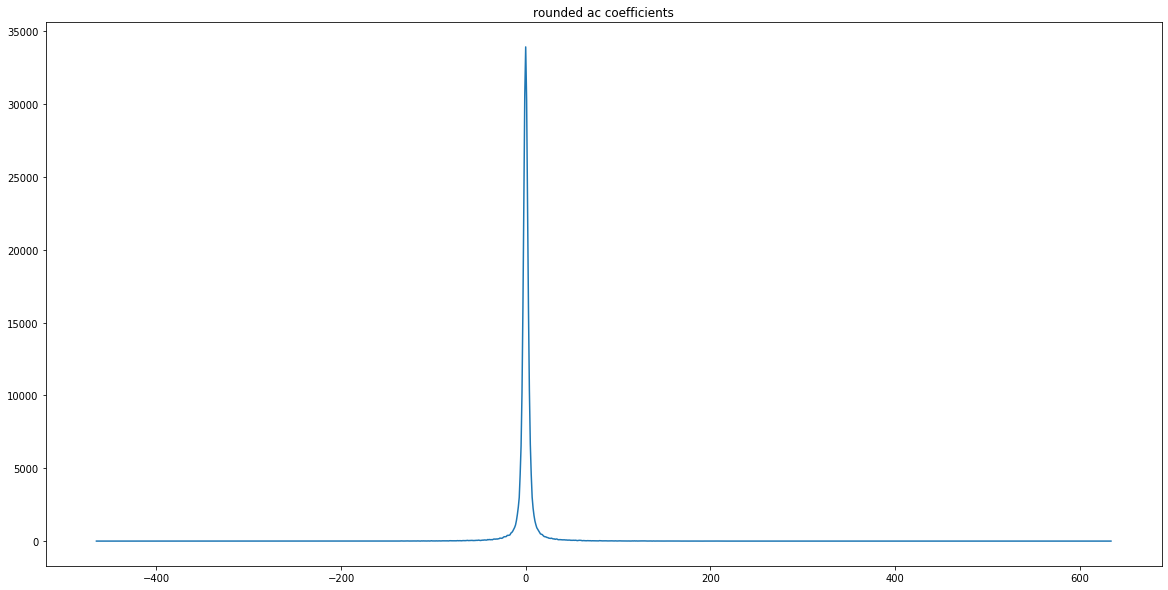

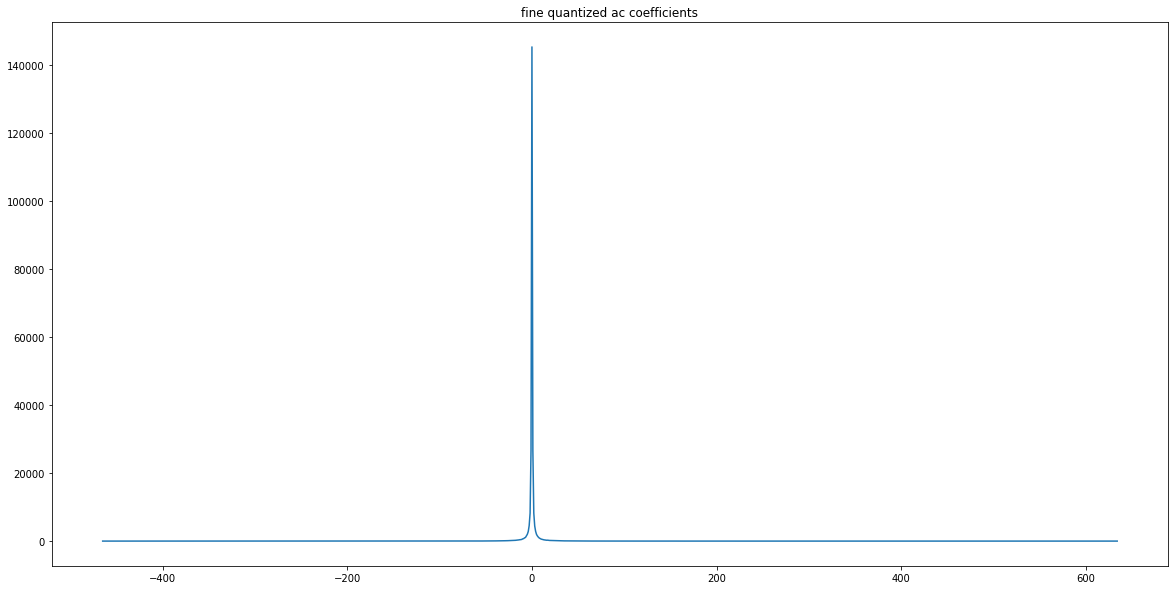

In [82]:
plt.figure(figsize=(20,10))
plt.title('rounded ac coefficients')
plt.plot(nq_u, nq_counts)
plt.savefig('rounded ac coefficients')


plt.figure(figsize=(20,10))
plt.title('fine quantized ac coefficients')
plt.plot(fq_u, fq_counts)
plt.savefig('fine quantized ac coefficients')

In [78]:
nq_u

array([-465., -444., -443., -429., -409., -408., -407., -401., -383.,
       -382., -379., -378., -377., -370., -361., -356., -352., -349.,
       -343., -339., -336., -331., -326., -323., -319., -315., -314.,
       -308., -305., -303., -301., -298., -294., -292., -288., -285.,
       -284., -280., -279., -278., -277., -273., -269., -266., -263.,
       -262., -260., -258., -254., -251., -250., -249., -247., -246.,
       -244., -241., -240., -239., -237., -235., -234., -233., -231.,
       -230., -229., -228., -227., -226., -225., -224., -223., -222.,
       -221., -220., -219., -218., -216., -215., -214., -213., -210.,
       -209., -208., -207., -206., -204., -203., -202., -201., -200.,
       -199., -198., -197., -196., -194., -192., -191., -190., -189.,
       -188., -187., -186., -185., -184., -182., -181., -180., -179.,
       -178., -177., -176., -175., -174., -173., -172., -171., -170.,
       -169., -168., -167., -166., -165., -164., -163., -162., -161.,
       -160., -159.,

In [79]:
nq_counts

array([    1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           2,     1,     1,     1,     1,     1,     1,     2,     2,
           1,     2,     1,     1,     1,     1,     1,     1,     1,
           1,     2,     2,     1,     1,     1,     3,     2,     2,
           2,     1,     1,     1,     1,     1,     2,     3,     3,
           1,     1,     5,     4,     3,     3,     3,     1,     1,
           2,     1,     2,     1,     3,     1,     3,     1,     1,
           3,     4,     2,     1,     3,     1,     2,     4,     1,
           3,     2,     3,     2,     2,     3,     4,     3,     5,
           1,     2,     2,     5,     2,     5,     3,     2,     1,
           2,     1,     5,     3,     3,     6,     3,     2,     2,
           8,     3,     3,     5,     4,     5,     7,     4,     7,
           7,     8,

In [80]:
fq_u

array([-465., -444., -443., -429., -409., -408., -407., -401., -383.,
       -382., -379., -378., -377., -370., -361., -356., -352., -349.,
       -343., -339., -336., -331., -326., -323., -319., -315., -314.,
       -308., -305., -303., -301., -298., -294., -292., -288., -285.,
       -284., -280., -279., -278., -277., -273., -269., -266., -263.,
       -262., -260., -258., -254., -251., -250., -249., -247., -246.,
       -244., -241., -240., -239., -237., -235., -234., -233., -231.,
       -230., -229., -228., -227., -226., -225., -224., -223., -222.,
       -221., -220., -219., -218., -216., -215., -214., -213., -210.,
       -209., -208., -207., -206., -204., -203., -202., -201., -200.,
       -199., -198., -197., -196., -194., -192., -191., -190., -189.,
       -188., -187., -186., -185., -184., -182., -181., -180., -179.,
       -178., -177., -176., -175., -174., -173., -172., -171., -170.,
       -169., -168., -167., -166., -165., -164., -163., -162., -161.,
       -160., -159.,

In [81]:
fq_counts

array([     1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      2,      1,      1,      1,      1,
            1,      1,      2,      2,      1,      2,      1,      1,
            1,      1,      1,      1,      1,      1,      2,      2,
            1,      1,      1,      3,      2,      2,      2,      1,
            1,      1,      1,      1,      2,      3,      3,      1,
            1,      4,      4,      2,      3,      3,      1,      1,
            2,      1,      2,      1,      3,      1,      2,      1,
            1,      3,      4,      2,      1,      3,      1,      2,
            3,      1,      3,      2,      3,      2,      2,      3,
            4,      3,      5,      1,      2,      2,      5,      2,
            5,      3,      2,      1,      2,      1,      5,      2,
      